### Downloading the Dataset

In [ ]:
!pip install kaggle


In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


### Performing EDA

In [8]:
import os

base_dir = "chest_xray"
for folder in ["train", "test", "val"]:
    print(folder, os.listdir(os.path.join(base_dir, folder)))


train ['NORMAL', 'PNEUMONIA']
test ['NORMAL', 'PNEUMONIA']
val ['NORMAL', 'PNEUMONIA']


In [9]:
def count_images(path):
    return len(os.listdir(path))

train_normal = count_images("chest_xray/train/NORMAL")
train_pneumonia = count_images("chest_xray/train/PNEUMONIA")

print("NORMAL:", train_normal)
print("PNEUMONIA:", train_pneumonia)


NORMAL: 1341
PNEUMONIA: 3875


##### Dataset is imbalanced with significantly more pneumonia cases.

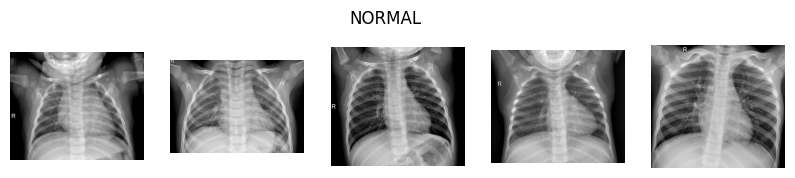

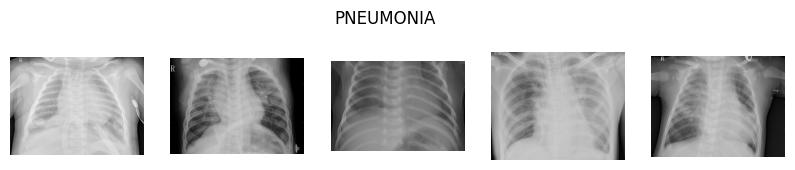

In [10]:
# Visualizing Samples

import matplotlib.pyplot as plt
from PIL import Image
import random

def show_images(folder, title):
    images = random.sample(os.listdir(folder), 5)
    plt.figure(figsize=(10,2))
    for i, img in enumerate(images):
        plt.subplot(1,5,i+1)
        plt.imshow(Image.open(os.path.join(folder, img)), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images("chest_xray/train/NORMAL", "NORMAL")
show_images("chest_xray/train/PNEUMONIA", "PNEUMONIA")


### Creating Image Data Generators

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    # Geometric transformations
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,

    # Flip options
    horizontal_flip=True,
    vertical_flip=False,  # Usually not for medical images

    # Brightness & contrast
    brightness_range=[0.8, 1.2],

    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

###Creating Data Loaders

In [12]:
train_data = train_gen.flow_from_directory(
    "chest_xray/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_data = test_gen.flow_from_directory(
    "chest_xray/val",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    "chest_xray/test",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Giving Class Weights

In [13]:
class_weight = {
    0: train_pneumonia / train_normal,  # NORMAL will have more penalty
    1: 1.0                               # PNEUMONIA
}


### Model Training

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


In [15]:
# Transfer Learning

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)


In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    class_weight=class_weight,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 704ms/step - accuracy: 0.6805 - loss: 0.8810 - precision: 0.8488 - recall: 0.6906 - val_accuracy: 0.8750 - val_loss: 0.3143 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.8828 - loss: 0.4182 - precision: 0.9649 - recall: 0.8738 - val_accuracy: 0.8750 - val_loss: 0.3145 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 632ms/step - accuracy: 0.9025 - loss: 0.3486 - precision: 0.9720 - recall: 0.8956 - val_accuracy: 0.8750 - val_loss: 0.2888 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.9000 - loss: 0.3672 - precision: 0.9691 - recall: 0.8929 - val_accuracy: 0.8750 - val_loss: 0.2673 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623

### Fine Tuning

In [19]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [21]:
model.fit(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 658ms/step - accuracy: 0.8753 - loss: 0.3072 - val_accuracy: 0.8125 - val_loss: 0.2513
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 627ms/step - accuracy: 0.9111 - loss: 0.2248 - val_accuracy: 0.8125 - val_loss: 0.3846
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 627ms/step - accuracy: 0.9256 - loss: 0.1986 - val_accuracy: 0.7500 - val_loss: 0.5195
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 627ms/step - accuracy: 0.9316 - loss: 0.1760 - val_accuracy: 0.7500 - val_loss: 0.5827
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9373 - loss: 0.1640 - val_accuracy: 0.7500 - val_loss: 0.5696
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.9449 - loss: 0.1349 - val_accuracy: 0.7500 - val_loss: 0.5135
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.9380 - loss: 0.1494 - val_accuracy: 0.8125 - val_loss: 0.4142
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accuracy: 0.9521 -

### Saving Model

In [38]:
model.save("mobilenetv2_pneumonia.keras")


In [40]:
from google.colab import files
files.download("mobilenetv2_pneumonia.keras")   # or model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(test_data)
y_pred = (preds > 0.5).astype(int)

print(classification_report(test_data.classes, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step
              precision    recall  f1-score   support

           0       0.96      0.68      0.80       234
           1       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    # Geometric transformations
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,

    # Flip options
    horizontal_flip=True,
    vertical_flip=False,  # Usually not for medical images

    # Brightness & contrast
    brightness_range=[0.8, 1.2],

    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

<Axes: >

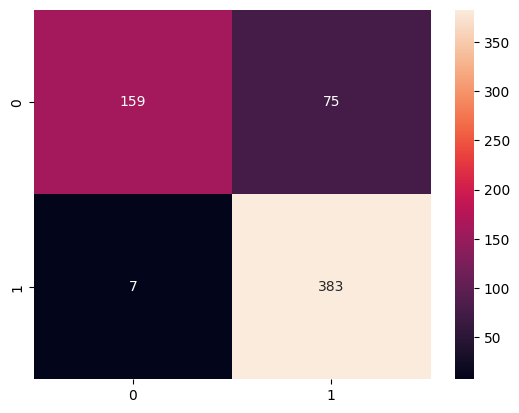

In [25]:
# confusion matrix

import seaborn as sns

cm = confusion_matrix(test_data.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


### GRAD CAM

##### importing libraries and model

In [26]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [27]:
model = tf.keras.models.load_model("mobilenetv2_pneumonia.h5")


In [ ]:
# finding last convolution layer

model.summary()



In [29]:
last_conv_layer_name = "Conv_1"


In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()


### Load and Prepare Image

In [31]:
from tensorflow.keras.preprocessing import image

img_path = "chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [32]:
raw_heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name
)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [33]:
print(
    "RAW heatmap min/max:",
    raw_heatmap.min(),
    raw_heatmap.max(),
    "mean:",
    raw_heatmap.mean()
)


RAW heatmap min/max: 0.013426803 0.99755824 mean: 0.59733087


In [34]:
# Read image (OpenCV uses BGR)
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))

# Resize raw heatmap (still float 0–1)
heatmap_resized = cv2.resize(
    raw_heatmap,
    (img.shape[1], img.shape[0])
)

# Convert ONLY for visualization
heatmap_uint8 = np.uint8(255 * heatmap_resized)

# Apply colormap
heatmap_color = cv2.applyColorMap(
    heatmap_uint8,
    cv2.COLORMAP_JET
)

# Overlay
superimposed_img = cv2.addWeighted(
    img, 0.6, heatmap_color, 0.4, 0
)


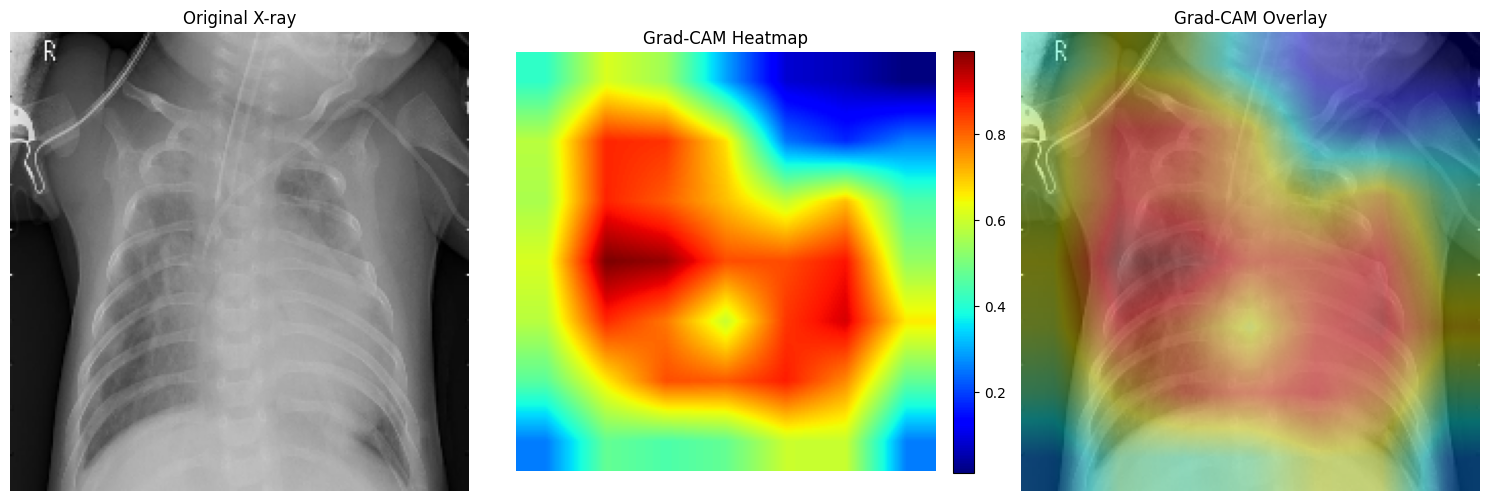

In [35]:
import matplotlib.pyplot as plt
import cv2

# 1. Original X-ray (RGB)
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224,224))
orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# 2. Raw Grad-CAM heatmap (0–1)
plt_heatmap = cv2.resize(raw_heatmap, (224,224))

# 3. Grad-CAM overlay (already computed earlier)
overlay_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# ---- Plot all three side-by-side ----
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig_img_rgb)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(plt_heatmap, cmap="jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay_rgb)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
